<a href="https://colab.research.google.com/github/Vaseema004/urban-planning-and-design/blob/main/Untitled21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.4696 - loss: 0.9498
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.2623
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0411
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0056
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 3.0775e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


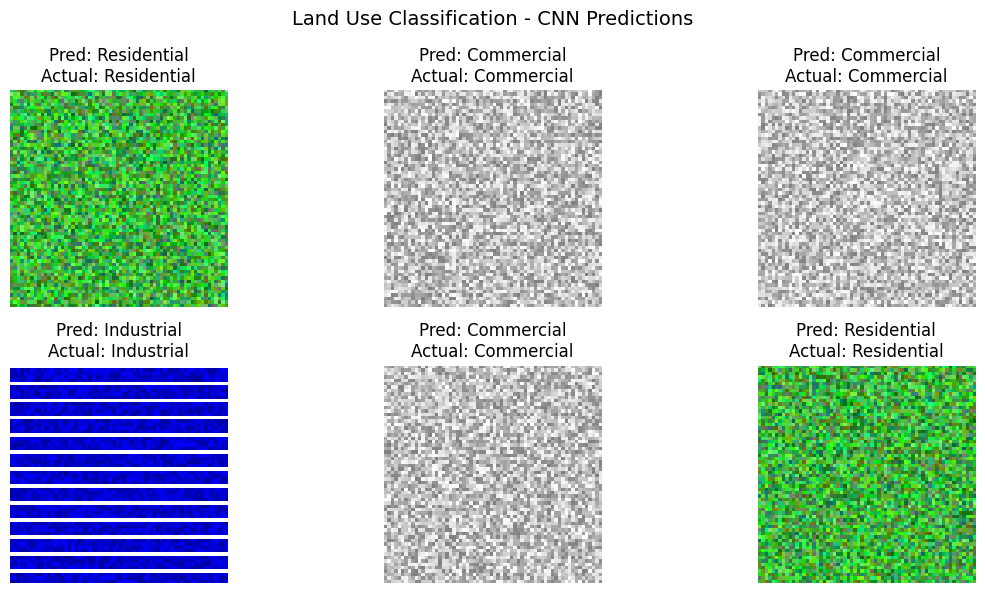

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 94437.0469
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 91086.9688
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 92903.3359
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 92118.1406 
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 93372.1328 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


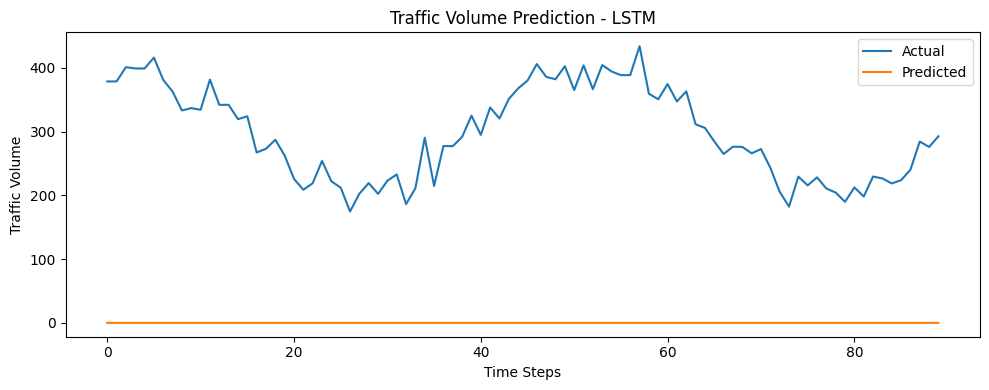

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split

# ---------- 1. LAND USE CLASSIFICATION ----------
def generate_class_image(label, img_size=64):
    img = np.zeros((img_size, img_size, 3))

    if label == 0:  # Residential (green)
        img[:, :, 1] = np.random.uniform(0.4, 1.0, (img_size, img_size))
        img[:, :, 0] = np.random.uniform(0.0, 0.5, (img_size, img_size))
        img[:, :, 2] = np.random.uniform(0.0, 0.5, (img_size, img_size))

    elif label == 1:  # Commercial (gray/white)
        base = np.random.uniform(0.5, 1.0, (img_size, img_size))
        img[:, :, 0] = base
        img[:, :, 1] = base
        img[:, :, 2] = base

    elif label == 2:  # Industrial (blue + stripes)
        img[:, :, 2] = np.random.uniform(0.6, 1.0, (img_size, img_size))
        for i in range(0, img_size, 5):
            img[i:i+1, :, :] = 1.0  # white horizontal lines

    return np.clip(img, 0, 1)

def simulate_classified_images(num_samples=150, img_size=64, num_classes=3):
    X = []
    y = []

    for _ in range(num_samples):
        label = np.random.randint(0, num_classes)
        X.append(generate_class_image(label, img_size))
        y.append(label)

    X = np.array(X)
    y_cat = to_categorical(y, num_classes)
    return X, y_cat, np.array(y)

# Simulate structured image data
X_img, y_img, y_raw = simulate_classified_images()
classes = ['Residential', 'Commercial', 'Industrial']

# Split data
X_train, X_test, y_train, y_test, y_train_raw, y_test_raw = train_test_split(X_img, y_img, y_raw, test_size=0.2)

# CNN model
cnn = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
cnn.fit(X_train, y_train, epochs=5, batch_size=16, verbose=1)

# Predict on test data
preds = cnn.predict(X_test)
pred_labels = np.argmax(preds, axis=1)

# Visualize results
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f"Pred: {classes[pred_labels[i]]}\nActual: {classes[y_test_raw[i]]}")
plt.suptitle("Land Use Classification - CNN Predictions", fontsize=14)
plt.tight_layout()
plt.show()

# ---------- 2. TRAFFIC VOLUME PREDICTION ----------

def simulate_traffic_data(time_steps=100):
    base = np.linspace(0, 4 * np.pi, time_steps)
    traffic = (np.sin(base) + np.random.normal(0, 0.2, time_steps)) * 100 + 300
    return traffic

traffic = simulate_traffic_data()

# Prepare LSTM data
window = 10
X_traffic, y_traffic = [], []
for i in range(len(traffic) - window):
    X_traffic.append(traffic[i:i + window])
    y_traffic.append(traffic[i + window])
X_traffic = np.array(X_traffic).reshape(-1, window, 1)
y_traffic = np.array(y_traffic)

# LSTM model
lstm = Sequential([
    LSTM(50, input_shape=(window, 1)),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_traffic, y_traffic, epochs=5, verbose=1)

# Predict
predicted = lstm.predict(X_traffic)

# Plot traffic prediction
plt.figure(figsize=(10, 4))
plt.plot(y_traffic, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title("Traffic Volume Prediction - LSTM")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.tight_layout()
plt.show()